## Predict features' categories and evaluate performance (deli lines)

In [1]:
import os
import openai
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay
import sklearn
from sklearn.metrics import mean_squared_error,mean_absolute_error,f1_score,classification_report
import numpy as np
import matplotlib.pyplot as plt
import random
openai.api_key = os.getenv("OPENAI_API_KEY")

## Get predictions

In [2]:
df=pd.read_csv("../../input_data/complete_file.csv")


preprompt="Consider this situation and answer the question that follows:\nSituation:"

df=df.assign(statement=preprompt+df.scenario+"\nQuestion: ")

df=df.loc[(df.study=='lines') & (df.condition.isin(['deli','bathroom','airport'])),:].reset_index(drop=True)

In [3]:
f2="How much worse off/better off is the first person in line? Answer with one of the following: \"a lot worse off\", \"a little worse off\", \"not affected\", a \"little better off\", or \"a lot better off\""
f3="How much worse off/better off is the person that cut in line? Answer with one of the following: \"a lot worse off\", \"a little worse off\", \"not affected\", a \"little better off\", or \"a lot better off\""
f1b="Did the person already wait in line once? Answer yes or no."
f1a="What is the most common thing people are trying to get by standing in this line?"
f1a2="Is this person trying to get that thing when they skip to the front of the line? Answer with yes or no."


In [4]:
df=df.assign(feat2_cat=np.where(df.feature2<=-25,"1. a lot worse",
                                        np.where(df.feature2<=-5,"2. a little worse",
                                        np.where(df.feature2<=5,"3. not affected",
                                        np.where(df.feature2<=25,"4. a little better","5. a lot better")))))
df=df.assign(feat3_cat=np.where(df.feature3<=-25,"1. a lot worse",
                                        np.where(df.feature3<=-5,"2. a little worse",
                                        np.where(df.feature3<=5,"3. not affected",
                                        np.where(df.feature3<=25,"4. a little better","5. a lot better")))))
df=df.assign(feat1b_cat=np.where(df.feature1b==1,"1. yes",
                                        np.where(df.feature1b==0,"2. no","None")))

In [5]:
for i,d in df.iterrows():
    input_prompt=d['statement']+f2
    #print(input_prompt)
    completion = openai.Completion.create(engine="text-davinci-002", prompt=input_prompt,temperature=0,max_tokens=60)
    df.loc[i,'first_response']=completion.choices[0].text
    
    
    input_2=d['statement']+"\nQuestion: "+f3+"\n"
    second_response = openai.Completion.create(engine="text-davinci-002", prompt=input_2,temperature=0,max_tokens=60)
    df.loc[i,'second_response']=second_response.choices[0].text

    
    input_3=d['statement']+"\nQuestion: "+f1b+"\n"
    third_response = openai.Completion.create(engine="text-davinci-002", prompt=input_3,temperature=0,max_tokens=60)
    df.loc[i,'third_response']=third_response.choices[0].text
    resp_final=df.loc[i,'third_response']


## Assign categories

In [6]:
df=df.assign(predf2=
    np.where(df.first_response.str.lower().str.contains('a lot worse'),'1. a lot worse',
    np.where(df.first_response.str.lower().str.contains('a little worse'),'2. a little worse',
    np.where(df.first_response.str.lower().str.contains('not affected'),'3. not affected',
    np.where(df.first_response.str.lower().str.contains('a little better'),'4. a little better',
    np.where(df.first_response.str.lower().str.contains('a lot better'),
             '5. a lot better',"None"))))))

df=df.assign(predf3=
    np.where(df.second_response.str.lower().str.contains('a lot worse'),'1. a lot worse',
    np.where(df.second_response.str.lower().str.contains('a little worse'),'2. a little worse',
    np.where(df.second_response.str.lower().str.contains('not affected'),'3. not affected',
    np.where(df.second_response.str.lower().str.contains('a little better'),'4. a little better',
    np.where(df.second_response.str.lower().str.contains('a lot better'),
             '5. a lot better',"None"))))))

df=df.assign(predf1b=
    np.where(df.third_response.str.lower().str.contains("yes"),"1. yes",
    np.where(df.third_response.str.lower().str.contains('no'),'2. no',"None")))

df=df.assign(gpt_feature2=
    np.where(df.first_response.str.lower().str.contains('a lot worse'),-50,
    np.where(df.first_response.str.lower().str.contains('a little worse'),-25,
    np.where(df.first_response.str.lower().str.contains('not affected'),0,
    np.where(df.first_response.str.lower().str.contains('a little better'),25,
    np.where(df.first_response.str.lower().str.contains('a lot better'),
             50,None))))))

df=df.assign(gpt_feature3=
    np.where(df.second_response.str.lower().str.contains('a lot worse'),-50,
    np.where(df.second_response.str.lower().str.contains('a little worse'),-25,
    np.where(df.second_response.str.lower().str.contains('not affected'),0,
    np.where(df.second_response.str.lower().str.contains('a little better'),25,
    np.where(df.second_response.str.lower().str.contains('a lot better'),
            50,None))))))

df=df.assign(gpt_feature1b=
    np.where(df.third_response.str.lower().str.contains("yes"),1,
    np.where(df.third_response.str.lower().str.contains('no'),0,None)))

df=df.assign(gpt_feature1c=None)

## Assign random features

In [7]:
random.seed(0)

l = [random.randint(0,4) for i in range(df.shape[0])]

df=df.assign(feat2_rand=l)

df=df.assign(feat2_rands=
    np.where(df.feat2_rand==0,'1. a lot worse',
    np.where(df.feat2_rand==1,'2. a little worse',
    np.where(df.feat2_rand==2,'3. not affected',
    np.where(df.feat2_rand==3,'4. a little better',
    np.where(df.feat2_rand==4,'5. a lot better',"None"))))))

l = [random.randint(0,4) for i in range(df.shape[0])]

df=df.assign(feat3_rand=l)

df=df.assign(feat3_rands=
    np.where(df.feat3_rand==0,'1. a lot worse',
    np.where(df.feat3_rand==1,'2. a little worse',
    np.where(df.feat3_rand==2,'3. not affected',
    np.where(df.feat3_rand==3,'4. a little better',
    np.where(df.feat3_rand==4,'5. a lot better',"None"))))))

l = [random.randint(0,1) for i in range(df.shape[0])]

df=df.assign(feat1b_rand=l)

df=df.assign(feat1b_rands=
    np.where(df.feat1b_rand==0,'1. yes',
    np.where(df.feat1b_rand==1,'2. no',"None")))

## Evaluate

### Feature 2

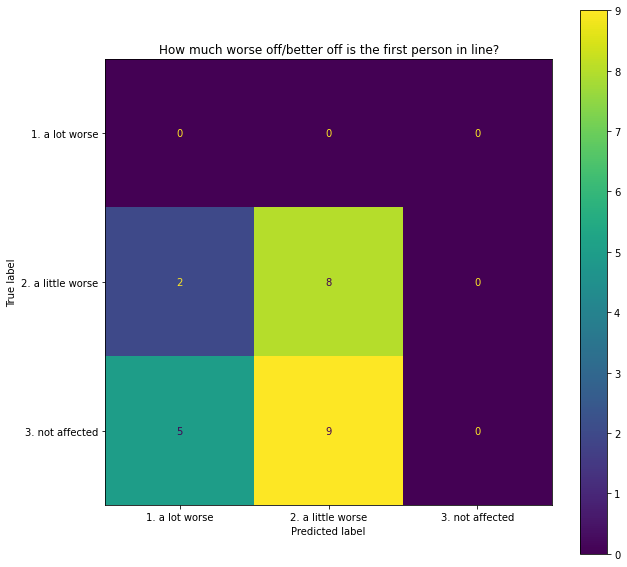

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df.feat2_cat,df.predf2,ax=ax)
plt.title("How much worse off/better off is the first person in line?")
plt.show()

In [9]:
gen=classification_report(df.feat2_cat,df.predf2,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  24.69
Accuracy:  33.33


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(

In [10]:
gen=classification_report(df.feat2_cat,df.feat2_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  23.57
Accuracy:  16.67


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Feature 3

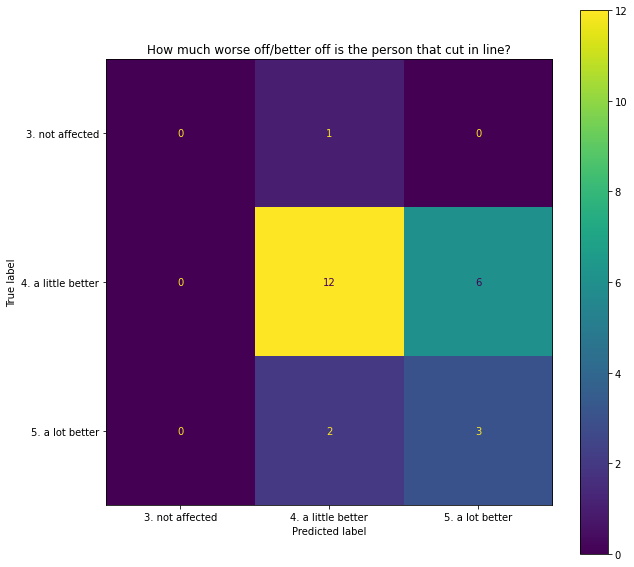

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df.feat3_cat,df.predf3,ax=ax)
plt.title("How much worse off/better off is the person that cut in line?")
plt.show()

In [12]:
gen=classification_report(df.feat3_cat,df.predf3,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  63.47
Accuracy:  62.50


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

In [13]:
gen=classification_report(df.feat3_cat,df.feat3_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  38.83
Accuracy:  29.17


/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/feradauto/miniconda3/envs/scirex/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Feature 1

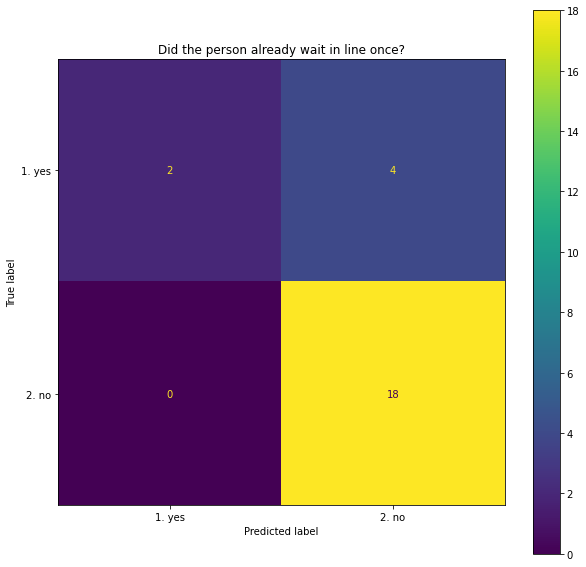

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(df.feat1b_cat,df.predf1b,ax=ax)
plt.title("Did the person already wait in line once?")
plt.show()

In [15]:
gen=classification_report(df.feat1b_cat,df.predf1b,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Features prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Features prediction
F1:  80.00
Accuracy:  83.33


In [16]:
gen=classification_report(df.feat1b_cat,df.feat1b_rands,digits=4,output_dict=True)

f1w="{0:.2f}".format(100*gen['weighted avg']['f1-score'])
accuracy="{0:.2f}".format(100*gen['accuracy'])

print("Random prediction")
print("F1: ",f1w)
print("Accuracy: ",accuracy)

Random prediction
F1:  49.27
Accuracy:  45.83


In [17]:
df.to_csv("../../outputs/analysis/features/deli_featues.csv",index=False)

In [62]:
#deli=df.loc[:,['context', 'condition', 'study', 'human.response', 'feature1',
#       'feature2', 'gpt_feature2','feature3', 'gpt_feature3','feature1b','gpt_feature1b', 'feature1c','gpt_feature1c', 'prompt',
#       'prompt_short', 'prompt_long']]

#deli.to_csv("./deli_features_categorical.csv",index=False)